In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import warnings
from copy import deepcopy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2, gaussian_kde
from scipy.special import erfinv, erf
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns
from matplotlib.colors import LogNorm

from settings import poles, ngc1068, txs0506
from tools import get_mids, array_source_interp
from fluxes import (
    atmo_background,
    astro_flux,
    plot_spectrum,
    power_law,
    cut_off,
    parabola_index
)



Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
warnings.filterwarnings("ignore")

def reset_mpl_settings():
    plt.style.use("../style.mplstyle")
    colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    return colorlist
colorlist = reset_mpl_settings()


In [4]:
contour_formats = {
    "IceCube": {"colors": [poles["IceCube"]["color"]], "linestyles": "--"},
    "Plenum-1": {"colors": [poles["Plenum-1"]["color"]], "linestyles": poles["Plenum-1"]["ls"]},
    "Plenum-2": {"colors": [poles["Plenum-2"]["color"]], "linestyles": poles["Plenum-2"]["ls"]},
}
e_smearing_files = sorted(glob("../resources/*energy_smearing_kde.pckl"))
sigma5 = 1 - erf(5 / np.sqrt(2))
public_data_hist = np.genfromtxt("../resources/IC86_II_smearing.csv", skip_header=1)

# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins_old, sindec_bins_old, aeff_2d_base = pickle.load(f)

logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

80 log_10(energy) bins
90 declination bins


In [6]:
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))

# Background

In [7]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))


# Energy resolution function

## Load resolution function

In [8]:
# energy smearing matrix
with open("../resources/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)

# artificial, improved smearing matrix
with open("../resources/improved_0.5_artificial_energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
artificial_normed_kvals = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)


## original and artificial energy resolution

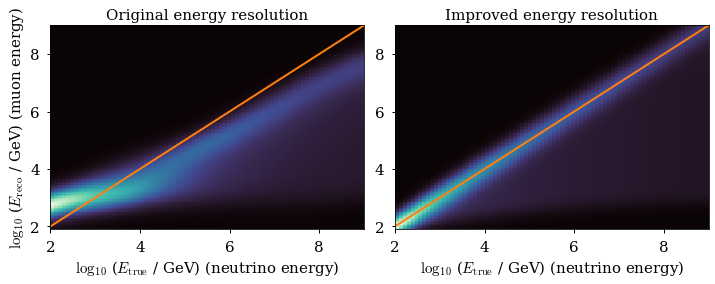

In [9]:
# logE_mids are the same as for effective area binning
f, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].grid(False)
axes[0].pcolormesh(logE_bins, logE_reco_bins, normed_kvals)
# f.colorbar()
axes[0].plot([1, 10], [1, 10], color="tab:orange")
axes[0].set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes[0].set_xlim(np.min(logE_bins), np.max(logE_bins))
axes[0].set_title("Original energy resolution")
axes[0].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[0].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")

## Artificial
axes[1].grid(False)
axes[1].pcolormesh(logE_bins, logE_reco_bins, artificial_normed_kvals)
# f.colorbar()
axes[1].plot([1, 10], [1, 10], color="tab:orange")
axes[1].set_ylim(np.min(logE_reco_bins), np.max(logE_reco_bins))
axes[1].set_xlim(np.min(logE_bins), np.max(logE_bins))
axes[1].set_title("Improved energy resolution")
# axes[1].set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes[1].set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
f.tight_layout()
f.savefig("../plots/energy_resolution_comparison.pdf", bbox_inches="tight")

# NGC1068 and TXS 0506+056 - source parameters

In [10]:
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
lt_kde = LIVETIME = 3186 * 24 * 3600
# LIVETIME = 10 * 360 * 24 * 3600 # 360 days of data taking per year

# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt("../resources/ngc_paper_68_contour.txt")
phi_c_68 /= 1E11
# gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")


# TXS parameters
with open("../resources/txs_contour.pkl", "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = txs_contour["best-fit"][0]
PHI_TXS = txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 


In [11]:

# analysis region in distance to source
delta_psi = 2
## check event numbers
aeff_factor_signal = (
    array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth
)
k_s = astro_flux(
    "powerlaw",
    aeff_factor_signal,
    emids,
    E0_NGC,
    GAMMA_NGC,
    1,
    phi_0=PHI_NGC,
)
print("ngc 1068:", np.sum(k_s))


# check the event numbers
aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth
    )
k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        phi_0=PHI_TXS,
    )
print("txs 0506+056:", np.sum(k_s))

ngc 1068: 83.5704046180578
txs 0506+056: 4.850817817243998


## PL+Cut: source parameters

In [12]:
# parabola parameters (not used)
# Alpha_NGC = 1
# Beta_NGC = 1
# E_para_norm = 3E2

# cutoff parameters
Gamma_cut = 2.0
logE_cut = 3.7 # log10 (Ecut / GeV)



### scale the fluxes such that the event numbers match


In [13]:
aeff_factor_signal = array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth
astro_ev_sum_pl = np.sum(
    astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        1,
        logE_cut,
        phi_0=PHI_NGC,
        #smear_energy=False,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)


flux_scaling_cut 0.9746408743525072



### Plot flux and event expectation


powerlaw with cutoff 83.5704046180578
power law: 83.57040461805781


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


powerlaw with cutoff 166.09096443548935
power law: 163.30235235277345
powerlaw with cutoff 83.5704046180578
power law: 83.57040461805781


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


powerlaw with cutoff 166.09096443548935
power law: 163.30235235277345


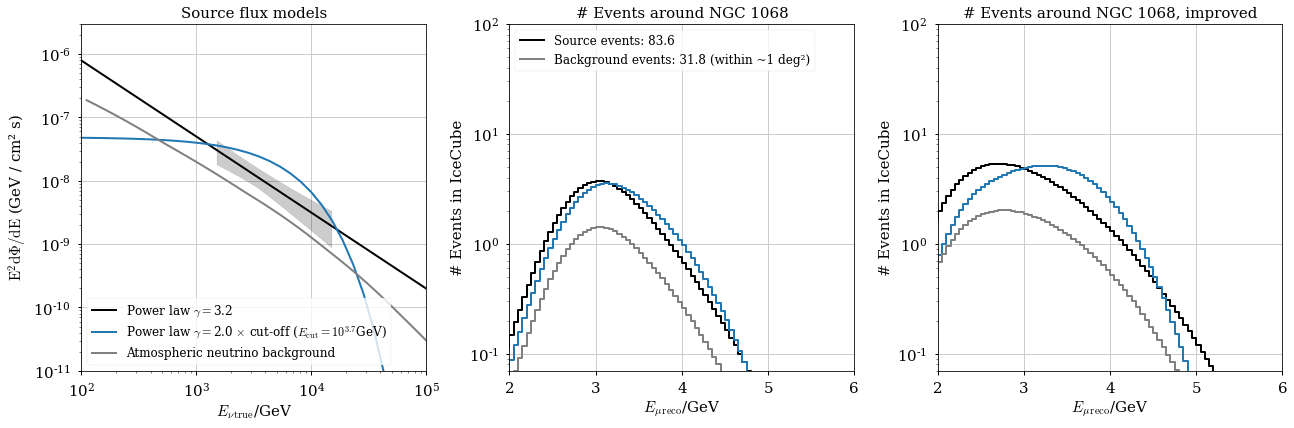

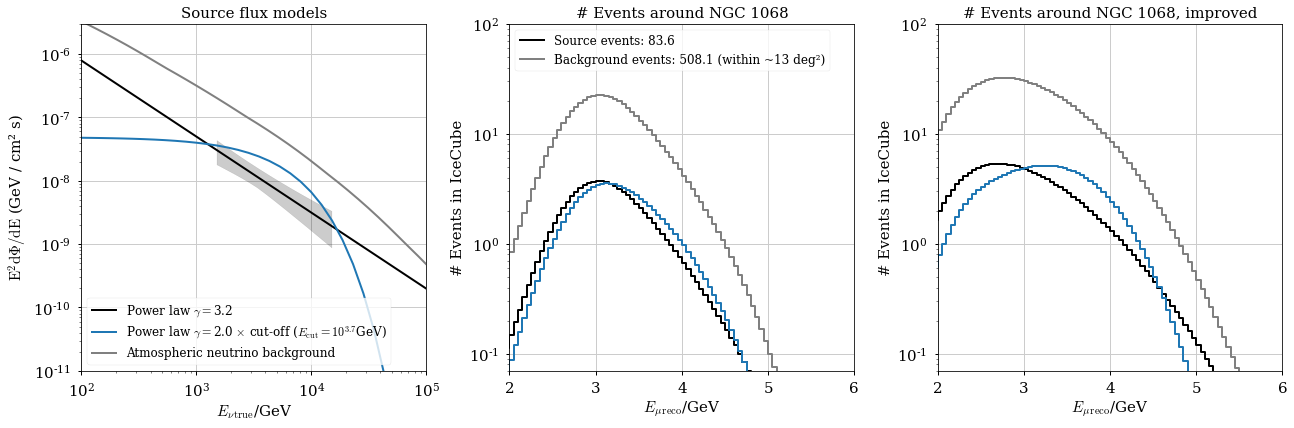

In [13]:
for delta_psi in [0.5, 2]:
    sq_deg = np.pi * delta_psi**2
    x_evals = np.logspace(0, 9, 100)
    y_scaling = 2

    pl = power_law(x_evals, E0_NGC, GAMMA_NGC, PHI_NGC)
    cut = power_law(x_evals, E0_NGC, Gamma_cut, PHI_NGC * flux_scaling_cut) * cut_off(
        x_evals, 10**logE_cut
    )

    f, axes = plt.subplots(ncols=3, figsize=(18, 6))
    ax = axes[0]
    ax.set_title("Source flux models")

    # error contour
    # with energy range interval
    x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
    # without energy range interval
    # x_cont = np.logspace(1.9, 5.1, 100)
    c_low = np.zeros_like(x_cont)
    c_high = np.zeros_like(x_cont)
    for ii, xe in enumerate(x_cont):
        tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
        c_low[ii] = np.min(tmp)
        c_high[ii] = np.max(tmp)
    ax.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.2,
    )

    ax.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${GAMMA_NGC}",
        color="k",
        alpha=1,
    )

    ax.plot(
        x_evals,
        cut * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${Gamma_cut} $\times$ cut-off ($E_{{\rm cut}}=10^{{{logE_cut:1.1f}}}$GeV)",
        color="tab:blue",
    )
    ax.plot(
        emids,
        array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids)* (np.deg2rad(delta_psi) ** 2) * np.pi
        * (emids**y_scaling),
        label="Atmospheric neutrino background",
        color="gray",
    )

    ax.set_yscale("log")
    ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
    ax.set_xscale("log")
    ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
    ax.set_ylim(1e-11, 3e-6)
    # ax.set_ylim(3e-6, 1e-3)
    ax.set_xlim(1e2, 1e5)
    ax.legend(loc=3, fontsize=12)


    ### plot Event numbers in E_reco
    for ii, (nkv, evals) in enumerate(zip([normed_kvals, artificial_normed_kvals], [logE_reco_mids, logE_reco_mids])):
        ax = axes[1 + ii]
        ident = "IceCube"
        aeff_factor_bckg = (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        aeff_factor_signal = (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
        )
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        use_e_reco = True
        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids),
            normed_kvals=nkv,
        )

        # cutoff
        k_s_cut = astro_flux(
            "powerlaw with cutoff",
            aeff_factor_signal,
            emids,
            E0_NGC,
            Gamma_cut,
            flux_scaling_cut,
            logE_cut,
            normed_kvals=nkv,
            phi_0=PHI_NGC,
        )
        print("powerlaw with cutoff", np.sum(k_s_cut))

        # powerlaw
        k_s_pl = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            normed_kvals=nkv,
            phi_0=PHI_NGC,
        )
        print("power law:", np.sum(k_s_pl))

        _ = plot_spectrum(
            evals,
            [
                k_s_pl,
                k_s_cut,
                k_b,
            ],
            [
                f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
                "",
                f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
                if ii == 0
                else "",
            ],
            "# Events around NGC 1068" if ii == 0 else "# Events around NGC 1068, improved",
            f,
            ax,
            xlim=(2, 6),
            ylim=(7e-2, 1e2),
            color=["k", "tab:blue", "gray"],  # "darkred",
            xlabel=r"$E_{\mu \, \rm reco}$/GeV",
            ylabel="# Events in IceCube",
        )
        if ii == 1:
            ax.get_legend().remove()
        else:
            ax.legend(loc=2, fontsize=12)

    f.savefig(f"../plots/ngc_spectral_dpsi-{delta_psi}.pdf", bbox_inches="tight")
delta_psi = 2


# PSF-Energy functions from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

In [16]:
logE_sm_min, logE_sm_max = public_data_hist[:, 0], public_data_hist[:, 1]
logE_sm_mids = (logE_sm_min + logE_sm_max) / 2.0
dec_sm_min, dec_sm_max = public_data_hist[:, 2], public_data_hist[:, 3]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0
log_psf_min, log_psf_max = np.log10(public_data_hist[:, 6]), np.log10(
    public_data_hist[:, 7]
)
psf_mids = (public_data_hist[:, 6] + public_data_hist[:, 7]) / 2.0
log_psf_mids = np.log10(psf_mids)
fractional_event_counts = public_data_hist[:, 10]


## Full 2D psi-energy LLH of sources around the horizon

### select the right declination bin for sources around the horizon


NOTE: psi changes per detector over the day. Not yet implemented, effect probably negligible. We choose the horizontal resolution for all detectors

In [17]:
## np.unique(dec_sm_min/max) -> [-90, -10, 10, +90]
mask = dec_sm_mids == 0 # that's valid for both ngc1068 and txs0506

## set up the psi2-energy function and binning
e_psi_kdes = gaussian_kde(
    (logE_sm_mids[mask], log_psf_mids[mask]), weights=fractional_event_counts[mask]
)

# psi² representation
delta_psi = 2
bins_per_psi2 = 25
psi2_bins = np.linspace(0, delta_psi**2, delta_psi**2 * bins_per_psi2 + 1)
psi2_mids = get_mids(psi2_bins)
log_psi_mids = np.log10(np.sqrt(psi2_mids))
# KDE was produced in log(E_true) and log(Psi)
e_eval, psi_eval = np.meshgrid(logE_mids, log_psi_mids)
psi_kvals = e_psi_kdes([e_eval.flatten(), psi_eval.flatten()]).reshape(
    len(log_psi_mids), len(logE_mids)
)

# new grid for analysis in psi^2 and e_reco after energy smearing
e_grid, psi_grid = np.meshgrid(logE_mids, psi2_mids)
e_psi2_grid = psi_kvals / psi_grid / 2 / np.log(10)
# normalize per energy to ensure that signal event numbers are not changed
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


Text(0.5, 0, 'log10(E/GeV)')

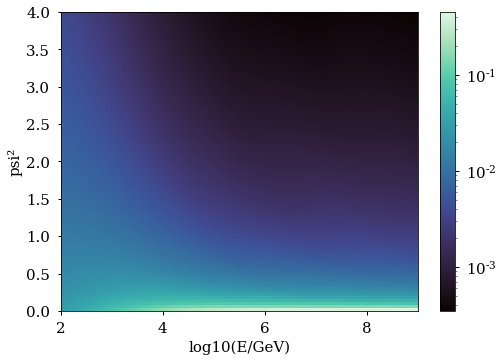

In [18]:
plt.figure()
plt.pcolormesh(logE_mids, psi2_mids, e_psi2_grid, norm=LogNorm())
plt.colorbar()
plt.ylabel("psi²")
plt.xlabel("log10(E/GeV)")

## Set up LLH function

In [18]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    src_dec,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(src_dec, spl_vals, sindec_mids),
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# NGC 1068

### Significance test Background vs. Background + Signal

In [18]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids),
        normed_kvals=normed_kvals
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
        normed_kvals=normed_kvals
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_NGC,
        phi_0=PHI_NGC,
        normed_kvals=normed_kvals,
        src_dec=ngc1068.dec.rad,
    )
    # fix signal contribution to 0
    local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), shape="powerlaw", **dct)
    global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("")


IceCube
Asimov data sum:
Background: 508.12721938513477
Signal: 83.57040461805781
Atmo-only normalization: [1.16447056]
Signal fit parameters: [1.00000525 3.19978329 0.99976589]
-2 Delta LLH: 18.750882383203134
P-VALUE: 8.478082240714081e-05 SIGNIFICANCE: 3.9304675880259397

Plenum-1
Asimov data sum:
Background: 2142.1932681141807
Signal: 354.9116539068826
Atmo-only normalization: [1.16567702]
Signal fit parameters: [1.00000619 3.19999765 0.99996058]
-2 Delta LLH: 74.7101648687676
P-VALUE: 5.982653188148713e-17 SIGNIFICANCE: inf

Plenum-2
Asimov data sum:
Background: 5436.214773648811
Signal: 896.7148970198456
Atmo-only normalization: [1.16495205]
Signal fit parameters: [0.99999906 3.19998591 0.99996385]
-2 Delta LLH: 196.20052243537793
P-VALUE: 2.4865539125849005e-43 SIGNIFICANCE: inf



## disc pot (5sigma) vs dec

In [21]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=5)

tmp = []
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        aeff_factor_bckg = (
            array_source_interp(dec, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_bckg += (
                array_source_interp(dec, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * (np.deg2rad(delta_psi) ** 2)
                * np.pi  # solid angle approx.
            ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(dec, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
        if "Plenum" in ident or "P-ONE" in ident:
            aeff_factor_signal += (
                array_source_interp(dec, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * e_psi2_grid
            )
        
        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals, sindec_mids),
            normed_kvals=normed_kvals,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=normed_kvals,
        )
        # calculate an estimate for the flux scaling
        # based on sig/sqrt(bckg) ~ 5 for 5 sigma
        sosb_scaler = 5 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        for scaler in np.logspace(np.log10(sosb_scaler / 2), np.log10(sosb_scaler * 2), num=20):
            tmp_dct = {"ident": ident, "dec": dec, "scaler": scaler}
            # model expectation for fitting
            mu_b_base = np.copy(aeff_factor_bckg)
            mu_s_base = np.copy(aeff_factor_signal)

            k_s = astro_flux(
                "powerlaw",
                aeff_factor_signal,
                emids,
                E0_NGC,
                GAMMA_NGC,
                scaler,
                phi_0=PHI_NGC,
                normed_kvals=normed_kvals,
            )
            k_i = k_s + k_b

            tmp_dct["SosB"] = np.sum(k_s) / np.sqrt(np.sum(k_b))
            tmp_dct["n_b"] = np.sum(k_b)
            tmp_dct["n_sig"] = np.sum(k_s)

            dct = dict(
                mu_b_base=mu_b_base,
                mu_s_base=mu_s_base,
                k_i=k_i,
                e_0=E0_NGC,
                phi_0=PHI_NGC,
                normed_kvals=normed_kvals,
                src_dec=dec,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], 3, 0), shape="powerlaw", **dct
            )
            global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, 3.0, 1.2),
                approx_grad=True,
            )

            tmp_dct["log10(p)"] = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))
            tmp.append(tmp_dct)
            del mu_b_base
            del mu_s_base

df = pd.DataFrame(tmp)

df.to_pickle("../resources/ngc_disc_pot.pickle")

 41%|████▏     | 12/29 [01:00<01:26,  5.08s/it]


KeyboardInterrupt: 

In [19]:
df = pd.read_pickle("../resources/ngc_disc_pot.pickle")


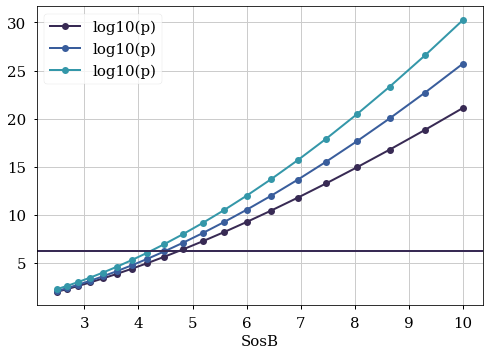

In [20]:
ax = df.loc[(df.ident=="IceCube") & (df.dec==0)].plot(x="SosB", y="log10(p)", marker="o")
df.loc[(df.ident=="Plenum-1") & (df.dec==0)].plot(x="SosB", y="log10(p)", marker="o", ax=ax)
df.loc[(df.ident=="Plenum-2") & (df.dec==0)].plot(x="SosB", y="log10(p)", marker="o", ax=ax)
plt.axhline(-np.log10(sigma5))


In [23]:
f = lambda x: np.power(
    10,
    np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
        np.log10(-np.log10(sigma5))
    ),
)
flux = pd.DataFrame(df.groupby(["ident", "dec"]).apply(f) * PHI_NGC, columns=["disc5"]).reset_index()


In [24]:
from settings import poles
# adjust labels
poles["IceCube"]["label"] = "IceCube (10yr)"
poles["P-ONE"]["label"] = "+ P-ONE (10yr)"
poles["Plenum-1"]["label"] = "+ Plenum-1 (10yr)"
poles["Plenum-2"]["label"] = "+ Plenum-2 (10yr)"


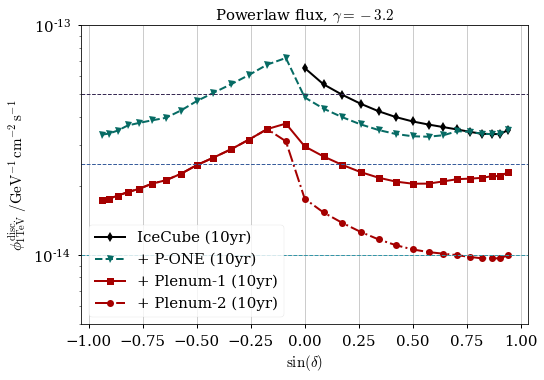

In [25]:

f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        **{k: poles[ident][k] for k in ["marker", "ls", "color", "label"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_NGC, ls="--", lw=1, color=colorlist[0]) #, label="NGC 1068 flux")
ax.axhline(PHI_NGC / 2, ls="--", lw=1, color=colorlist[1]) #, label="NGC 1068 flux / 2")
ax.axhline(PHI_NGC / 5, ls="--", lw=1, color=colorlist[2]) #, label="NGC 1068 flux / 5")

ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend()
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
ax.set_ylim(0.5e-14, 1e-13)
f.savefig("../plots/ngc_disc_pot.pdf", bbox_inches="tight")


## cross check with gamma=-3 


In [ ]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-70, 71, step=10)

tmp = []
for ident in idents:
    for dec in tqdm(np.deg2rad(decs)):
        #if ident == "IceCube" and dec <= np.deg2rad(-5):
        #    continue
        aeff_factor_bckg = (
            array_source_interp(dec, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid
        if "Plenum" in ident:
            aeff_factor_bckg += (
                array_source_interp(dec, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * (np.deg2rad(delta_psi) ** 2)
                * np.pi  # solid angle approx.
            ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(dec, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
        if "Plenum" in ident:
            aeff_factor_signal += (
                array_source_interp(dec, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * e_psi2_grid
            )
        
        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals, sindec_mids),
            normed_kvals=normed_kvals,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            3,
            1,
            phi_0=PHI_NGC,
            normed_kvals=normed_kvals,
        )
        # calculate an estimate for the flux scaling
        # based on sig/sqrt(bckg) ~ 5 for 5 sigma
        sosb_scaler = 5 / (np.sum(k_s) / np.sqrt(np.sum(k_b)))
        for scaler in np.logspace(np.log10(sosb_scaler / 2), np.log10(sosb_scaler * 2), num=20):
            tmp_dct = {"ident": ident, "dec": dec, "scaler": scaler}
            # model expectation for fitting
            mu_b_base = np.copy(aeff_factor_bckg)
            mu_s_base = np.copy(aeff_factor_signal)

            k_s = astro_flux(
                "powerlaw",
                aeff_factor_signal,
                emids,
                E0_NGC,
                3,
                scaler,
                phi_0=PHI_NGC,
                normed_kvals=normed_kvals,
            )
            k_i = k_s + k_b

            tmp_dct["SosB"] = np.sum(k_s) / np.sqrt(np.sum(k_b))
            tmp_dct["n_b"] = np.sum(k_b)
            tmp_dct["n_sig"] = np.sum(k_s)

            dct = dict(
                mu_b_base=mu_b_base,
                mu_s_base=mu_s_base,
                k_i=k_i,
                e_0=E0_NGC,
                phi_0=PHI_NGC,
                normed_kvals=normed_kvals,
                src_dec=dec,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], 3, 0), shape="powerlaw", **dct
            )
            global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, 3.0, 1.2),
                approx_grad=True,
            )

            tmp_dct["log10(p)"] = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))
            tmp.append(tmp_dct)
            del mu_b_base
            del mu_s_base

df = pd.DataFrame(tmp)


In [55]:
df.to_pickle("../resources/gamma3_disc_pot.pickle")

In [70]:
from scipy.interpolate import splev, splrep

In [71]:
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt('../resources/tcarver_10y_disc.csv', delimiter=',')
gamma = 2.5
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g25_tessaThesis.csv', delimiter=',')
gamma = 3.0
ps_disc[gamma] = np.genfromtxt('../resources/10yr_ps_dicPot_g3_tessaThesis.csv', delimiter=',')
### result from 7yr analysis, if wanted
disc_7yr = np.genfromtxt('../resources/PSdiscPot7years.csv', delimiter=',')
sdec_7yr = disc_7yr[:,0]
disc_7yr = disc_7yr[:,1]

for gamma in ps_disc:
    ind_disc[gamma] = np.argsort(ps_disc[gamma][:,0])
    xsd[gamma] = ps_disc[gamma][:,0][ind_disc[gamma] ]
    ic_10yr[gamma] = ps_disc[gamma][:,1][ind_disc[gamma] ]
    spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

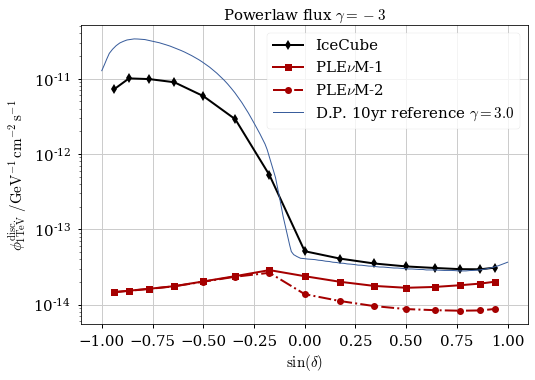

In [68]:
f = lambda x: np.power(
    10,
    np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
        np.log10(-np.log10(sigma5))
    ),
)
flux = pd.DataFrame(df.groupby(["ident", "dec"]).apply(f) * PHI_NGC, columns=["disc5"]).reset_index()


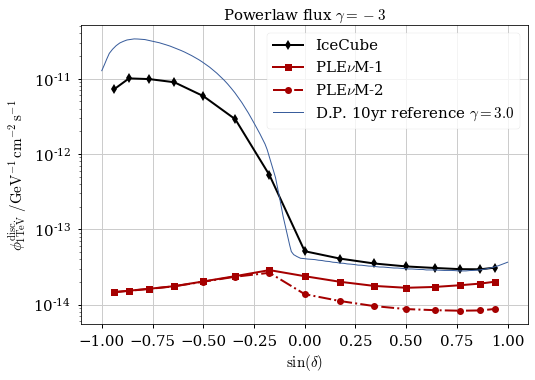

In [69]:

f, ax = plt.subplots()
for ident, series in flux.groupby(["ident"]):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        **{k: poles[ident][k] for k in ["marker", "ls", "color", "label"]}
    )

gamma = 3.0
ax.plot(xsd[gamma], ic_10yr[gamma] / 1E3, lw=1, color=colorlist[1], label=fr'D.P. 10yr reference $\gamma={gamma}$')

ax.legend()
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$")
#ax.set_ylim(0.5E-14, 1E-13)
ax.set_yscale("log")
ax.set_title(r"Powerlaw flux $\gamma=-3$")
f.savefig("../plots/gamma3_disc_pot.pdf", bbox_inches="tight")


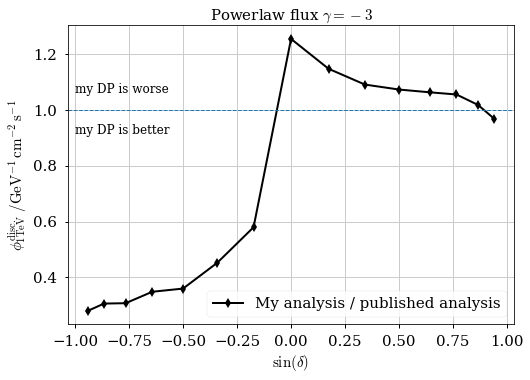

In [82]:

f, ax = plt.subplots()
ident = "IceCube"
series = flux.loc[flux.ident==ident]
gamma = 3.0

plt.plot(
    np.sin(series.dec),
    series.disc5 / splev(np.sin(series.dec), spl_10yr[gamma]) * 1E3,
    **{k: poles[ident][k] for k in ["marker", "ls", "color"]},
    label="My analysis / published analysis"
)
plt.axhline(1, ls="--", lw=1, color="tab:blue")
plt.text(-1, 0.95, "my DP is better", va="top", fontsize=12)
plt.text(-1, 1.05, "my DP is worse", va="bottom", fontsize=12)
ax.legend()
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$")
ax.set_title(r"Powerlaw flux $\gamma=-3$")
f.savefig("../plots/gamma3_disc_pot_ratio.pdf", bbox_inches="tight")


## Significance test Background vs. Background + Signal with improved energy resolution

In [27]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
    for ef in e_smearing_files:
        # energy smearing matrix
        with open(ef, "rb") as f:
            nkv, _ = pickle.load(f)
        # normalize per bin in true energy
        nkv = nkv / np.sum(nkv, axis=0)
        es_ident = ef.split("/")[-1].split("_energy")[0]
        print(es_ident)

        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids),
            normed_kvals=nkv,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
        )
        k_i = k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        dct = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
            src_dec=ngc1068.dec.rad,
        )
        # fix signal contribution to 0
        local_llh = lambda x: ps_llh_2d_composite((x[0], 3, 0), shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
        # ... and fit both hypotheses!
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        print("Atmo-only normalization:", out_bckg[0])

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 3.0, 1.2),
            approx_grad=True,
        )
        print("Signal fit parameters:", out_comp[0])
        # print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

        # calculate p-value and significance with Wilks'
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("")


IceCube
artificial
Atmo-only normalization: [1.16572658]
Signal fit parameters: [1.00006208 3.19989486 0.99984131]
P-VALUE: 0.00013374325576919168 SIGNIFICANCE: 3.8194616397462227

energy_smearing_kde.pckl
Atmo-only normalization: [1.16572483]
Signal fit parameters: [1.00000485 3.19996494 0.99994366]
P-VALUE: 0.00012816433896947822 SIGNIFICANCE: 3.82995952304137

idealized_artificial
Atmo-only normalization: [1.16572528]
Signal fit parameters: [0.99998716 3.19999231 0.99998334]
P-VALUE: 9.972170027124674e-05 SIGNIFICANCE: 3.8912680279744216

improved_0.05_artificial
Atmo-only normalization: [1.16572675]
Signal fit parameters: [0.99998681 3.19999594 0.99999794]
P-VALUE: 9.78346347683751e-05 SIGNIFICANCE: 3.895900289468655

improved_0.1_artificial
Atmo-only normalization: [1.16572495]
Signal fit parameters: [0.9999887  3.19997773 0.99997744]
P-VALUE: 9.61062516894574e-05 SIGNIFICANCE: 3.900217645744997

improved_0.2_artificial
Atmo-only normalization: [1.1657259]
Signal fit parameters: [

## 1D scan of power-law parameters

In [42]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
num = 50
gamma_astro_scaling = np.linspace(2.5, 3.8, num=num + 1)
astro_scaling = np.logspace(-1.5, 0.3, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
shape = "powerlaw"

for ident in idents:
    print(ident)
    for kvi in ["standard", "improved"]:
        print(kvi)
        nkv = normed_kvals if kvi == "standard" else artificial_normed_kvals

        aeff_factor_bckg = (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid
        if "Plenum" in ident:
            aeff_factor_bckg += (
                array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * (np.deg2rad(delta_psi) ** 2)
                * np.pi  # solid angle approx.
            ) * bckg_grid

        aeff_factor_signal = (
            array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
            * LIVETIME
            * ewidth
            * e_psi2_grid
        )
        if "Plenum" in ident:
            aeff_factor_signal += (
                array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
                * LIVETIME
                * ewidth
                * e_psi2_grid
            )
        # model expectation for fitting
        mu_b_base = deepcopy(aeff_factor_bckg)
        mu_s_base = deepcopy(aeff_factor_signal)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids),
            normed_kvals=nkv,
        )
        k_s = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_NGC,
            GAMMA_NGC,
            1,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
        )
        k_i = k_s + k_b

        print("Asimov data sum:")
        print("Background:", np.sum(k_b))
        print("Signal:", np.sum(k_s))

        ## global minimum
        dct = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            normed_kvals=nkv,
            src_dec=ngc1068.dec.rad,
        )
        global_llh = lambda x: ps_llh_2d_composite(
            x, shape="powerlaw", **dct
        )
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 2.8, 1.2),
            approx_grad=True,
        )
        if out[2]["warnflag"] != 0:
            print("WARNING!!")
        print("bf param:", out[0])

        bf_SPL["ts"][ident + kvi] = out[1]
        bf_SPL["conv"][ident + kvi] = out[0][0]
        bf_SPL["gamma"][ident + kvi] = out[0][1]
        bf_SPL["phi_astro"][ident + kvi] = out[0][2]

        print("starting local gamma scan...")
        local_SPL_gamma_scan["ts"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        local_SPL_gamma_scan["conv"][ident + kvi] = np.zeros(len(gamma_astro_scaling))
        local_SPL_gamma_scan["phi_astro"][ident + kvi] = np.zeros(
            len(gamma_astro_scaling)
        )
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed gamma
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], gas, x[1]), shape="powerlaw", **dct
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2),
                bounds=[(0.1, 3), (0.1, 3)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (
                local_SPL_gamma_scan["conv"][ident + kvi][j],
                local_SPL_gamma_scan["phi_astro"][ident + kvi][j],
            ) = local_out[0]
            local_SPL_gamma_scan["ts"][ident + kvi][j] = local_out[1]

        print("starting local phi scan...")
        local_SPL_phi_scan["ts"][ident + kvi] = np.zeros(len(astro_scaling))
        local_SPL_phi_scan["conv"][ident + kvi] = np.zeros(len(astro_scaling))
        local_SPL_phi_scan["gamma"][ident + kvi] = np.zeros(len(astro_scaling))
        for j, asc in enumerate(astro_scaling):
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], x[1], asc), shape="powerlaw", **dct
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 2.8),
                bounds=[(0.1, 3), (1, 6)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (
                local_SPL_phi_scan["conv"][ident + kvi][j],
                local_SPL_phi_scan["gamma"][ident + kvi][j],
            ) = local_out[0]
            local_SPL_phi_scan["ts"][ident + kvi][j] = local_out[1]
        print("done")
        print("")


IceCube
standard
Asimov data sum:
Background: 479.55085343059574
Signal: 79.47365242225797
bf param: [1.00014176 3.20014951 0.9995398 ]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:
Background: 479.55085343059574
Signal: 79.47365242225796
bf param: [1.00001448 3.20004421 0.99991859]
starting local gamma scan...
starting local phi scan...
done

Plenum-1
standard
Asimov data sum:
Background: 2013.974104006386
Signal: 335.8922827691626
bf param: [0.99999832 3.20001565 1.00001539]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:
Background: 2013.9741040063857
Signal: 335.89228276916253
bf param: [1.00005722 3.20003664 0.99998053]
starting local gamma scan...
starting local phi scan...
done

Plenum-2
standard
Asimov data sum:
Background: 5119.902171630979
Signal: 850.6227767910163
bf param: [0.99999973 3.20004217 1.00002903]
starting local gamma scan...
starting local phi scan...
done

improved
Asimov data sum:

Text(0, 0.5, '-2$\\Delta$LLH')

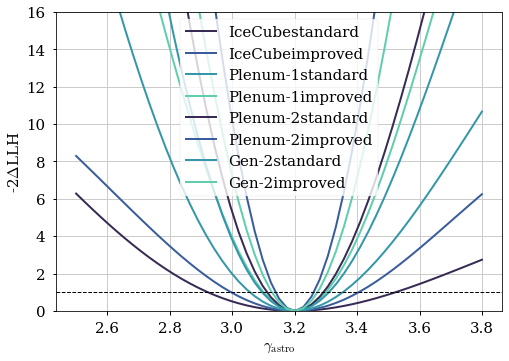

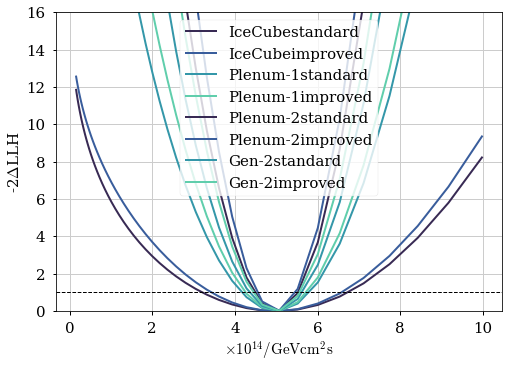

In [43]:
plt.figure()
for ident in local_SPL_gamma_scan["ts"].keys(): #idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_gamma_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        gamma_astro_scaling[mask],
        local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
#plt.xlim(2.1, 2.4)
plt.legend(loc="upper center")
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in local_SPL_phi_scan["ts"].keys(): #idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_phi_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        astro_scaling[mask] * (PHI_NGC * 1E14),
        local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
plt.legend(loc="upper center")
plt.xlabel(r"$\times 10^{14} / \rm GeV cm^2 s$")
plt.ylabel(r"-2$\Delta$LLH")


## 2D scan - parameters of 10yr PS Paper

IceCube
Asimov data sum:
Background: 541.8653711080178
Signal: 89.8007372002915
bf param: [1.00013146 3.20018982 0.99962411]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2275.676953679532
Signal: 379.53930256402543
bf param: [0.99999833 3.20001538 1.00001869]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 5785.200193933309
Signal: 961.1556799898492
bf param: [0.99999934 3.20004167 1.00003209]
starting local fits...
done
IceCube
Plenum-1
Plenum-2


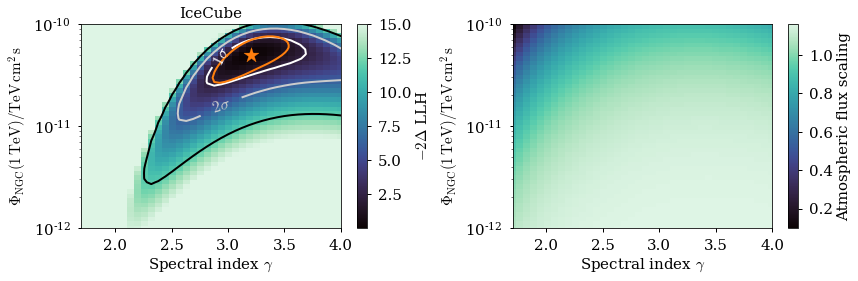

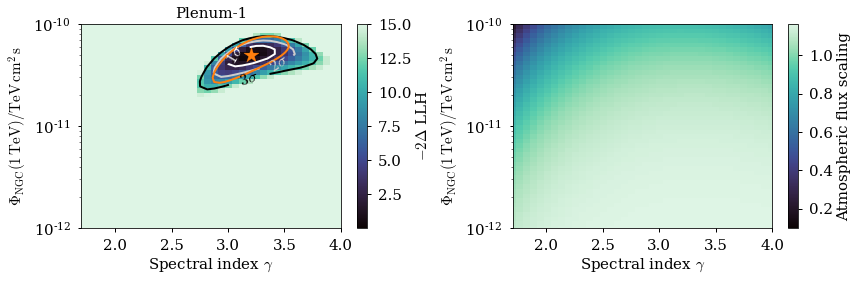

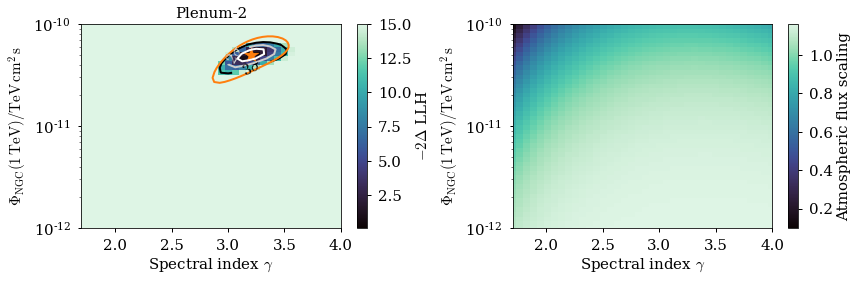

In [51]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.7, 4.8, num=num + 1)
astro_scaling = np.logspace(-1.7, 0.5, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d[ident], sindec_mids) * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids) * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids))
    k_s = astro_flux(
        "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    dct = dict(
            mu_b_base=mu_b_base,
            mu_s_base=mu_s_base,
            k_i=k_i,
            e_0=E0_NGC,
            phi_0=PHI_NGC,
            normed_kvals=normed_kvals,
            src_dec=ngc1068.dec.rad,
        )
    global_llh = lambda x: ps_llh_2d_composite(
            x, shape="powerlaw", **dct
    )
    ## global minimum
    out = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 2.8, 1.2),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed gamma and phi_astro
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], gas, asc), shape="powerlaw", **dct
            )
            local_out = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                bounds=[(0.1, 3)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


ref_color = "tab:orange"
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(12, 4))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["gamma"][ident],
        bf_SPL["phi_astro"][ident]
        * PHI_NGC
        * 1e3,  # match 10yr paper plot
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.plot(
        gamma_c_68,
        phi_c_68,
        color=ref_color,
        label=r"ngc paper",
    )
    # ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    f.tight_layout()
    f.savefig(f"../plots/2D_scan_ngc_spl_{ident}.pdf")


## Power law vs. Power-law with cutoff
### normal vs. improved E resolution

In [149]:
# livetime relative to 10yrs
detector_configurations = [
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.2_artificial_energy_smearing_rgi.pckl', "E_res": "20% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
]

detector_configurations = pd.DataFrame(detector_configurations)

### Significance

In [150]:
pvals_ngc = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "E_res"], sort=False
):
    print(es_ident, identifier)
    aeff_factor_bckg = (
        array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(ngc1068.dec.rad, aeff_2d["IceCube"], sindec_mids)
        * LIVETIME
        * ewidth
    )
    ## add the other detector configs to IceCube
    if series.key.iloc[0] != "IceCube":
        aeff_factor_bckg += (
            array_source_interp(ngc1068.dec.rad, aeff_2d[series.key.iloc[0]], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        aeff_factor_signal += (
            array_source_interp(ngc1068.dec.rad, aeff_2d[series.key.iloc[0]], sindec_mids)
            * LIVETIME
            * ewidth
        )

    aeff_factor_bckg = aeff_factor_bckg * bckg_grid
    aeff_factor_signal = aeff_factor_signal * e_psi2_grid

    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        rgi = pickle.load(f)
    nkv = rgi((lre_grid, lge_grid))
    # normalize per bin in true energy
    nkv = nkv / np.sum(nkv, axis=0)
    
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids),
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
        normed_kvals=nkv,
    )
    k_i = k_s + k_b

    if ii == 0:
        print(
            "Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s)
        )
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_NGC,
        phi_0=PHI_NGC,
        normed_kvals=nkv,
        src_dec=ngc1068.dec.rad,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.9, 1.1, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, Gamma_cut, flux_scaling_cut, logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, Gamma_cut, flux_scaling_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )


Baseline 10y IC
../resources/artificial_energy_smearing_rgi.pckl
bckg params: [0.97642574 3.17460629 1.13771279]
global params: [0.99640055 1.84254813 1.14458289 3.55921865]
true params: (1, 2.0, 0.974137664377099, 3.7)
P-VALUE: 0.47512048745616464 SIGNIFICANCE: 0.7141725517380607
pval check: 0.4663258057867723 ratio: 0.981489576009488

Removed bias 10y IC
../resources/idealized_artificial_energy_smearing_rgi.pckl
bckg params: [0.98858747 3.02342202 0.99097529]
global params: [1.00171787 1.84505048 0.96250231 3.62492286]
true params: (1, 2.0, 0.974137664377099, 3.7)
P-VALUE: 0.16752010801052425 SIGNIFICANCE: 1.3802161334324945
pval check: 0.166724171960543 ratio: 0.9952487133668083

20% improv. 10y IC
../resources/improved_0.2_artificial_energy_smearing_rgi.pckl
bckg params: [0.98844054 3.02693859 0.9939942 ]
global params: [1.0020382  1.85789908 0.95736267 3.63270847]
true params: (1, 2.0, 0.974137664377099, 3.7)
P-VALUE: 0.10807055130029283 SIGNIFICANCE: 1.6069262316494057
pval check

## Nice significance summary plot

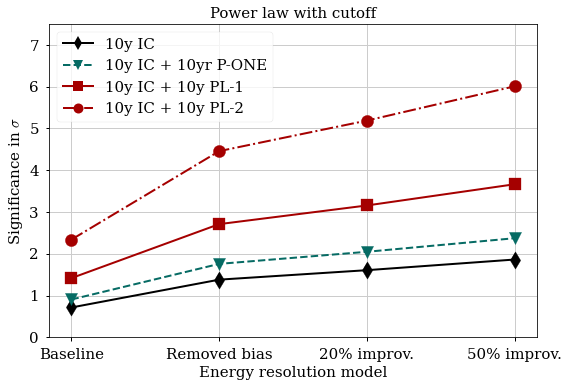

In [170]:
pval_df = pd.DataFrame(pvals_ngc)
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
for ident, series in pval_df.groupby(["key"]):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=poles[ident]["ls"],
        color=poles[ident]["color"],
        marker=poles[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[poles[ident]["color"]],
        s=150,
        zorder=10,
        marker=poles[ident]["marker"],
    )

ax.set_ylim(0, 7.5)
ax.legend(loc=2) #fontsize="x-small")
ax.set_title("Power law with cutoff")#, fontsize="small")
ax.set_xlabel("Energy resolution model")
ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/cutoff_sigma_vs_eres_ngc.pdf")


# Same for TXS 0506+056
## Parabola: source parameters

In [26]:
# parabola parameters
Alpha_TXS = 2
E_para_norm_TXS = 3E5
Beta_TXS = 1


### scale the fluxes such that the event numbers match


In [27]:
aeff_factor_signal = (
    array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"], sindec_mids)
    * LIVETIME
    * ewidth
)
astro_ev_sum_pl = np.sum(
    astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        phi_0=PHI_TXS,
    )
)

# parabola
astro_ev_sum_para = np.sum(
    astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm_TXS,
        Alpha_TXS,
        1,
        Beta_TXS,
        phi_0=PHI_TXS,
    )
)
# match event numbers
flux_scaling_para_txs = astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para_txs)


flux_scaling_para 0.35110631160171285



### Plot flux and event expectation


parabola 4.850817817243998
power law: 4.850817817243998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


parabola 9.70015993828287
power law: 9.688982758281163


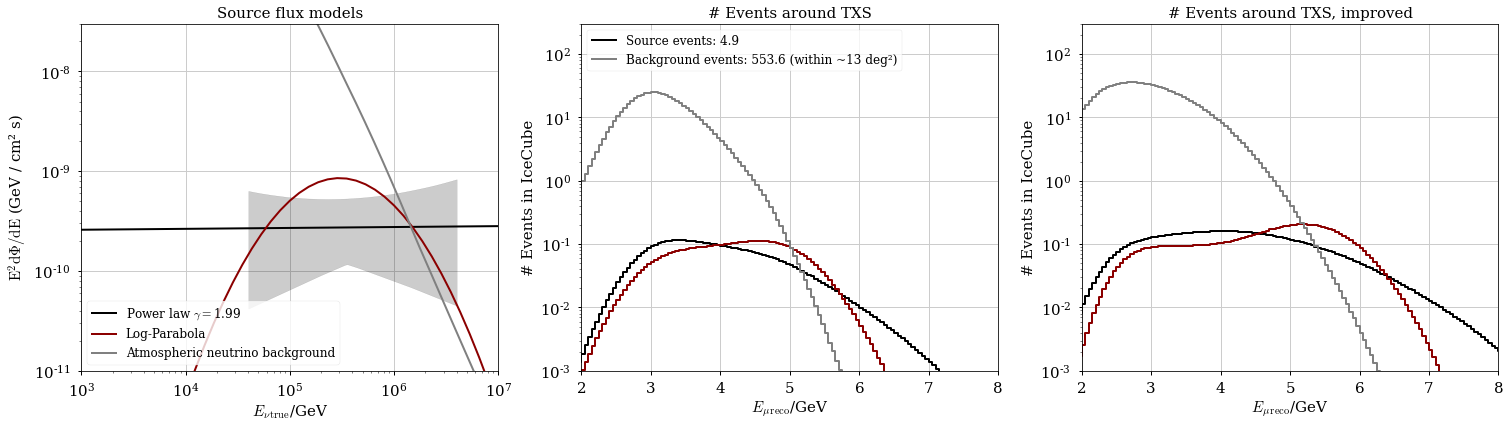

In [28]:
sq_deg = np.pi * delta_psi ** 2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, E0_TXS, GAMMA_TXS, PHI_TXS)
para_idx = parabola_index(Alpha_TXS, Beta_TXS, x_evals, E_para_norm_TXS)
para = power_law(x_evals, E_para_norm_TXS, para_idx, PHI_TXS * flux_scaling_para_txs)

f, axes = plt.subplots(ncols=3, figsize=(21, 6))
ax = axes[0]
ax.set_title("Source flux models")

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
# without energy range interval
# x_cont = np.logspace(3, 7, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(
        xe, E0_TXS, txs_contour["68\\%"][:,0], txs_contour["68\\%"][:,1] / 1e3 / 2.8
    )  ## fudge factor :)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont ** y_scaling),
    c_high * (x_cont ** y_scaling),
    color="k",
    alpha=0.2,
)


ax.plot(
    x_evals,
    pl * (x_evals ** y_scaling),
    label=rf"Power law $\gamma=${GAMMA_TXS:1.2f}",
    color="k",
    alpha=1,
)
ax.plot(x_evals, para * (x_evals ** y_scaling), label="Log-Parabola", color="darkred")
ax.plot(
    emids,
    array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids) * (emids ** y_scaling),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-11, 3e-8)
ax.set_xlim(1e3, 1e7)
ax.legend(loc=3, fontsize=12)


### plot Event numbers in E_reco
for ii, nkv in enumerate([normed_kvals, artificial_normed_kvals]):
    ax = axes[1 + ii]
    ident = "IceCube"
    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident], sindec_mids) * LIVETIME * ewidth
    )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    use_e_reco = True
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids),
        normed_kvals=nkv,
    )

    # parabola
    k_s_para = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm_TXS,
        Alpha_TXS,
        flux_scaling_para_txs,
        Beta_TXS,
        normed_kvals=nkv,
        phi_0=PHI_TXS,
    )
    print("parabola", np.sum(k_s_para))

    # powerlaw
    k_s_pl = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        normed_kvals=nkv,
        phi_0=PHI_TXS,
    )
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids
    _ = plot_spectrum(
        evals,
        [
            k_s_pl,
            k_s_para,
            k_b,
        ],
        [
            f"Source events: {np.sum(k_s_pl):1.1f}" if ii == 0 else "",
            "",
            f"Background events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)"
            if ii == 0
            else "",
        ],
        "# Events around TXS" if ii == 0 else "# Events around TXS, improved",
        f,
        ax,
        xlim=(2, 8),
        ylim=(1e-3, 3e2),
        color=["k", "darkred", "gray"],
        xlabel=r"$E_{\mu \, \rm reco}$/GeV",
        ylabel="# Events in IceCube",
    )
    if ii == 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc=2, fontsize=12)

f.savefig("../plots/txs_spectral.pdf", bbox_inches="tight")


## Spectral fit

In [29]:
# livetime relative to 10yrs
detector_configurations = [
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key":  "IceCube", "identifier": "10y IC", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key":    "P-ONE", "identifier": "10y IC + 10yr P-ONE", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key": "Plenum-1", "identifier": "10y IC + 10y PL-1", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/artificial_energy_smearing_rgi.pckl', "E_res": "Baseline"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/idealized_artificial_energy_smearing_rgi.pckl', "E_res": "Removed bias"},
{"key": "Plenum-2", "identifier": "10y IC + 10y PL-2", "e_file": '../resources/improved_0.5_artificial_energy_smearing_rgi.pckl', "E_res": "50% improv."},
]

detector_configurations = pd.DataFrame(detector_configurations)

In [30]:
pvals_txs_spectral = []
for (identifier, es_ident), series in detector_configurations.groupby(
    ["identifier", "E_res"], sort=False
):
    print(es_ident, identifier)
    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"], sindec_mids)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"], sindec_mids)
        * LIVETIME
        * ewidth
    )
    ## add the other detector configs to IceCube
    if series.key.iloc[0] != "IceCube":
        aeff_factor_bckg += (
            array_source_interp(txs0506.dec.rad, aeff_2d[series.key.iloc[0]], sindec_mids)
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )
        aeff_factor_signal += (
            array_source_interp(txs0506.dec.rad, aeff_2d[series.key.iloc[0]], sindec_mids)
            * LIVETIME
            * ewidth
        )

    aeff_factor_bckg = aeff_factor_bckg * bckg_grid
    aeff_factor_signal = aeff_factor_signal * e_psi2_grid

    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        rgi = pickle.load(f)
    nkv = rgi((lre_grid, lge_grid))
    # normalize per bin in true energy
    nkv = nkv / np.sum(nkv, axis=0)
    
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids),
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm_TXS,
        Alpha_TXS,
        flux_scaling_para_txs,
        Beta_TXS,
        phi_0=PHI_TXS,
        normed_kvals=nkv,
    )
    k_i = k_s + k_b

    if ii == 0:
        print(
            "Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s)
        )
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E_para_norm_TXS,
        phi_0=PHI_TXS,
        normed_kvals=nkv,
        src_dec=txs0506.dec.rad,
    )
    pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 2.0, 1.2),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="parabola", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.9, 0.3, 0.9),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, Alpha_TXS, flux_scaling_para_txs, Beta_TXS))

    # check the LLH at the "correct" parameter position
    check = comp( (1, Alpha_TXS, flux_scaling_para_txs, Beta_TXS))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_txs_spectral.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )


Baseline 10y IC
../resources/artificial_energy_smearing_rgi.pckl
bckg params: [0.99476284 2.04601519 0.16409864]
global params: [1.00015686 1.90105221 0.33591528 0.8961449 ]
true params: (1, 2, 0.35110631160171285, 1)
P-VALUE: 0.6317189902571201 SIGNIFICANCE: 0.4793087612605458
pval check: 0.6291981447442764 ratio: 0.996009546092927

Removed bias 10y IC
../resources/idealized_artificial_energy_smearing_rgi.pckl
bckg params: [0.99556487 2.03921196 0.15533489]
global params: [1.00014098 1.90238734 0.33693193 0.896056  ]
true params: (1, 2, 0.35110631160171285, 1)
P-VALUE: 0.6029953631280611 SIGNIFICANCE: 0.5200978696804481
pval check: 0.6001990535742758 ratio: 0.9953626350635943

50% improv. 10y IC
../resources/improved_0.5_artificial_energy_smearing_rgi.pckl
bckg params: [0.9953188  2.03403356 0.16015016]
global params: [1.00019875 1.90517677 0.33833703 0.89684262]
true params: (1, 2, 0.35110631160171285, 1)
P-VALUE: 0.47279620290609936 SIGNIFICANCE: 0.7179368862603502
pval check: 0.469

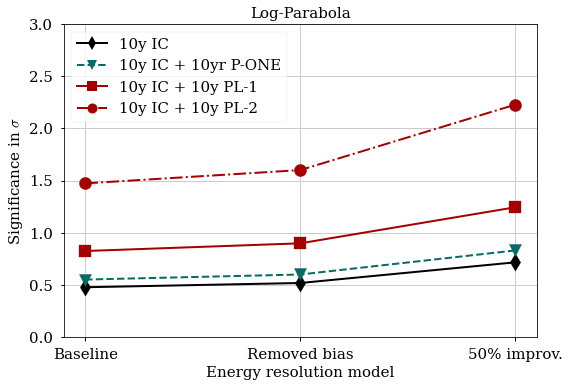

In [31]:
pval_df = pd.DataFrame(pvals_txs_spectral)
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
for ident, series in pval_df.groupby(["key"]):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=poles[ident]["ls"],
        color=poles[ident]["color"],
        marker=poles[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[poles[ident]["color"]],
        s=150,
        zorder=10,
        marker=poles[ident]["marker"],
    )

ax.set_ylim(0, 3)
ax.legend(loc=2) #fontsize="x-small")
ax.set_title("Log-Parabola")#, fontsize="small")
ax.set_xlabel("Energy resolution model")
ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/logparabola_sigma_vs_eres_txs.pdf")


## Varying livetime

IDEA: keep number of event fixed for different time window sizes
-> Vary LIVETIME of background

In [40]:
# livetime of background in days
detector_configurations = [
{"identifier": "IceCube", "livetime": 50},
{"identifier": "IceCube", "livetime": 100},
{"identifier": "IceCube", "livetime": 500},
{"identifier": "IceCube", "livetime": 1000},
{"identifier": "IceCube", "livetime": 3000},
{"identifier": "Plenum-1", "livetime": 50},
{"identifier": "Plenum-1", "livetime": 100},
{"identifier": "Plenum-1", "livetime": 500},
{"identifier": "Plenum-1", "livetime": 1000},
{"identifier": "Plenum-1", "livetime": 3000},
{"identifier": "Plenum-2", "livetime": 50},
{"identifier": "Plenum-2", "livetime": 100},
{"identifier": "Plenum-2", "livetime": 500},
{"identifier": "Plenum-2", "livetime": 1000},
{"identifier": "Plenum-2", "livetime": 3000},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [82]:
pvals_txs = []
for (identifier, livetime), series in detector_configurations.groupby(
    ["identifier", "livetime"]
):
    print(identifier, livetime, "days")
    if livetime != "full":
        livetime_bg = livetime * 24 * 3600
    else:
        livetime_bg = LIVETIME
    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d[identifier], sindec_mids)
        * livetime_bg
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d[identifier], sindec_mids)
        * LIVETIME  # we don't care about the signal livetime, it should just be a constant number of events here
        * ewidth
    )

    aeff_factor_bckg = aeff_factor_bckg * bckg_grid
    aeff_factor_signal = aeff_factor_signal * e_psi2_grid

    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids),
        normed_kvals=normed_kvals,
    )
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_TXS,
        GAMMA_TXS,
        1,
        normed_kvals=normed_kvals,
        phi_0=PHI_TXS,
    )
    k_i = k_s + k_b
    print("Asimov data sum: Background =", np.sum(k_b), ", Signal =", np.sum(k_s))
    dct = dict(
        mu_b_base=mu_b_base,
        mu_s_base=mu_s_base,
        k_i=k_i,
        e_0=E0_TXS,
        phi_0=PHI_TXS,
        normed_kvals=normed_kvals,
        src_dec=txs0506.dec.rad,
    )
    pl_func = lambda x: ps_llh_2d_composite((x[0], 2, 0), shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 3.0, 0.1),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.9, 1.1),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, GAMMA_TXS, 1))

    # check the LLH at the "correct" parameter position
    check = comp((1, GAMMA_TXS, 1))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_txs.append(
        {
            "identifier": identifier,
            "livetime": livetime_bg / 24 / 3600,
            "pval": pval,
            r"Significance in $\sigma$": significance,
            "n_ev": np.round(np.sum(k_s), 3)
        }
    )


IceCube 50 days
Asimov data sum: Background = 8.284759697967594 , Signal = 5.223146852398501
bckg params: [1.63136395 3.         0.1       ]
global params: [1.00166413 1.98998322 0.99684883]
true params: (1, 1.9909560723514212, 1)
P-VALUE: 8.411335914984933e-06 SIGNIFICANCE: 4.454437672062305
pval check: 8.411164423931535e-06 ratio: 0.9999796119124083

IceCube 100 days
Asimov data sum: Background = 16.56951939593519 , Signal = 5.223146852398501
bckg params: [1.31518381 3.         0.1       ]
global params: [1.00001724 1.99091227 1.00008666]
true params: (1, 1.9909560723514212, 1)
P-VALUE: 3.753635813455742e-05 SIGNIFICANCE: 4.1221432916672205
pval check: 3.753635707254419e-05 ratio: 0.9999999717070787

IceCube 500 days
Asimov data sum: Background = 82.84759697967597 , Signal = 5.223146852398501
bckg params: [1.06304657 3.         0.1       ]
global params: [0.99999684 1.99094942 0.99993386]
true params: (1, 1.9909560723514212, 1)
P-VALUE: 0.000987606866387363 SIGNIFICANCE: 3.2940336157

### nice plot

In [83]:
pval_df = pd.DataFrame(pvals_txs)

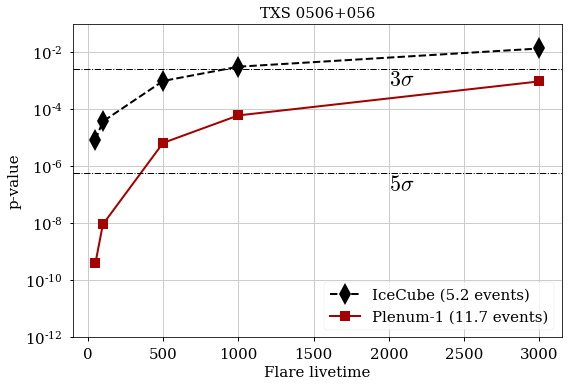

In [84]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
mask = pval_df.identifier == "IceCube"
ax.plot(
    pval_df.loc[mask]["livetime"],
    pval_df.loc[mask][r"pval"],
    #pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label=f"IceCube ({pval_df.loc[mask].n_ev.unique()[0]:1.1f} events)",
    ms=15,
)


## PLENUM-1
mask = pval_df.identifier == "Plenum-1"
ax.plot(
    pval_df.loc[mask]["livetime"],
    pval_df.loc[mask][r"pval"],
    #pval_df.loc[mask][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label=f"Plenum-1 ({pval_df.loc[mask].n_ev.unique()[0]:1.1f} events)",
    ms=10,
)


ax.set_ylim(1E-12, 1E-1)
ax.set_yscale("log")
ax.axhline(1 - erf(5 / np.sqrt(2)), lw=1, color="k", ls="-.")
ax.text(2000, 1 - erf(5 / np.sqrt(2)), r"$5 \sigma$", color="k", va="top", fontsize=22)
ax.axhline(1 - erf(3 / np.sqrt(2)), lw=1, color="k", ls="-.")
ax.text(2000, 1 - erf(3 / np.sqrt(2)), r"$3 \sigma$", color="k", va="top", fontsize=22)

ax.legend(loc=4) #fontsize="x-small")
ax.set_title("TXS 0506+056")#, fontsize="small")
ax.set_xlabel("Flare livetime")
ax.set_ylabel(r"p-value")
#ax.set_ylabel(r"Significance in $\sigma$")
f.tight_layout()
f.savefig("../plots/powerlaw_sigma_vs_livetime_txs.pdf")


## Discovery potential

In [72]:
# livetime of background in days
detector_configurations = [
{"identifier": "IceCube", "livetime": 5},
#{"identifier": "IceCube", "livetime": 20},
#{"identifier": "IceCube", "livetime": 50},
#{"identifier": "IceCube", "livetime": 100},
{"identifier": "IceCube", "livetime": 300},
{"identifier": "Plenum-1", "livetime": 5},
#{"identifier": "Plenum-1", "livetime": 20},
#{"identifier": "Plenum-1", "livetime": 50},
#{"identifier": "Plenum-1", "livetime": 100},
{"identifier": "Plenum-1", "livetime": 300},
{"identifier": "Plenum-2", "livetime": 5},
#{"identifier": "Plenum-2", "livetime": 20},
#{"identifier": "Plenum-2", "livetime": 50},
#{"identifier": "Plenum-2", "livetime": 100},
{"identifier": "Plenum-2", "livetime": 300},
]
detector_configurations = pd.DataFrame(detector_configurations)

In [90]:
decs = [-30, 0, 30]
tmp = []
for (identifier, livetime), series in detector_configurations.groupby(
    ["identifier", "livetime"]
):
    print(identifier, livetime, "days")
    if livetime != "full":
        livetime_bg = livetime * 24 * 3600
    else:
        livetime_bg = LIVETIME
    for dec in tqdm(np.deg2rad(decs)):
        if identifier == "IceCube" and dec <= np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue
        aeff_factor_bckg = (
            array_source_interp(dec, aeff_2d[identifier], sindec_mids)
            * livetime_bg
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        )

        aeff_factor_signal = (
            array_source_interp(dec, aeff_2d[identifier], sindec_mids)
            * LIVETIME  # we don't care about the actual signal livetime, it should just be a constant number of events here
            * ewidth
        )
        aeff_factor_bckg = aeff_factor_bckg * bckg_grid
        aeff_factor_signal = aeff_factor_signal * e_psi2_grid
        
        # asimov data
        k_b_ref = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals, sindec_mids),
            normed_kvals=normed_kvals,
        )
        k_s_ref = astro_flux(
            "powerlaw",
            aeff_factor_signal,
            emids,
            E0_TXS,
            GAMMA_TXS,
            1,
            normed_kvals=normed_kvals,
            phi_0=PHI_TXS,
        )
        # calculate an estimate for the flux scaling
        # based on sig/sqrt(bckg)
        sosb_scaler = 1.5 / (np.sum(k_s_ref) / np.sqrt(np.sum(k_b_ref)))
        for scaler in np.logspace(
            np.log10(sosb_scaler / 5), np.log10(sosb_scaler * 10), num=20
        ):
            tmp_dct = {
                "ident": identifier,
                "dec": dec,
                "scaler": scaler,
                "livetime": livetime,
            }
            # model expectation for fitting
            mu_b_base = np.copy(aeff_factor_bckg)
            mu_s_base = np.copy(aeff_factor_signal)

            k_s = astro_flux(
                "powerlaw",
                aeff_factor_signal,
                emids,
                E0_TXS,
                GAMMA_TXS,
                scaler,
                normed_kvals=normed_kvals,
                phi_0=PHI_TXS,
            )
            k_i = k_s + k_b_ref

            tmp_dct["SosB"] = np.sum(k_s) / np.sqrt(np.sum(k_b_ref))
            tmp_dct["SosB_central"] = np.sum(k_s[:10]) / np.sqrt(np.sum(k_b_ref[:10]))
            tmp_dct["n_b"] = np.sum(k_b_ref)
            tmp_dct["n_sig"] = np.sum(k_s)

            dct = dict(
                mu_b_base=mu_b_base,
                mu_s_base=mu_s_base,
                k_i=k_i,
                e_0=E0_TXS,
                phi_0=PHI_TXS,
                normed_kvals=normed_kvals,
                src_dec=dec,
            )
            # fix signal contribution to 0
            local_llh = lambda x: ps_llh_2d_composite(
                (x[0], 3, 0), shape="powerlaw", **dct
            )
            global_llh = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, 2.1, scaler),
                approx_grad=True,
            )
            tmp_dct["bg_norm_0"] = out_bckg[0][0]
            tmp_dct["bg_norm_1"] = out_comp[0][0]
            tmp_dct["sig_norm"] = out_comp[0][2]
            tmp_dct["sig_gamma"] = out_comp[0][1]
            tmp_dct["log10(p)"] = -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2))
            tmp.append(tmp_dct)
            del mu_b_base
            del mu_s_base

df = pd.DataFrame(tmp)
df.to_pickle("../resources/txs_disc_pot.pickle")


IceCube 5 days


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


IceCube 300 days


100%|██████████| 3/3 [00:10<00:00,  3.47s/it]


Plenum-1 5 days


100%|██████████| 3/3 [00:18<00:00,  6.10s/it]


Plenum-1 300 days


100%|██████████| 3/3 [00:11<00:00,  3.93s/it]


Plenum-2 5 days


100%|██████████| 3/3 [00:15<00:00,  5.32s/it]


Plenum-2 300 days


100%|██████████| 3/3 [00:13<00:00,  4.46s/it]


df = pd.read_pickle("../resources/txs_disc_pot.pickle")

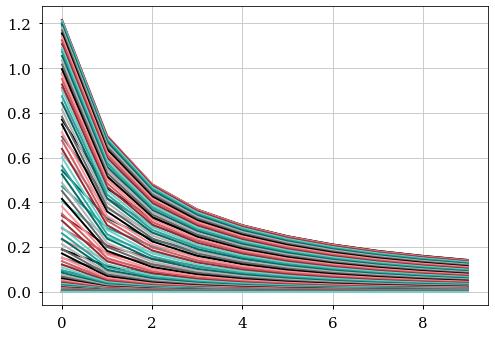

In [96]:
plt.plot(k_s[:10])

[]

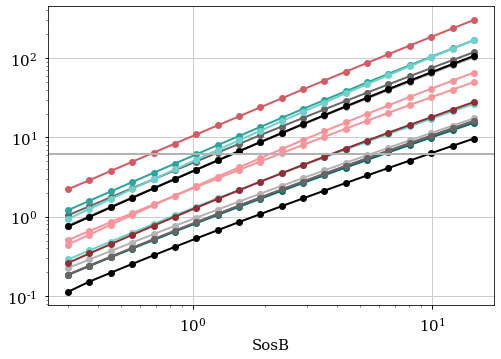

In [91]:
f, ax = plt.subplots()
df.groupby(["ident", "dec", "livetime"]).plot(x="SosB", y="log10(p)", marker="o", ax=ax, legend=False)
plt.axhline(-np.log10(sigma5))
plt.loglog()

[]

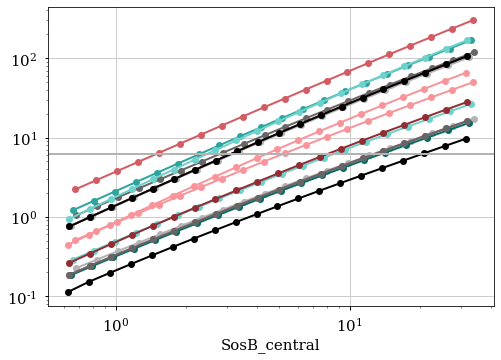

In [93]:
f, ax = plt.subplots()
df.groupby(["ident", "dec", "livetime"]).plot(x="SosB_central", y="log10(p)", marker="o", ax=ax, legend=False)
plt.axhline(-np.log10(sigma5))
plt.loglog()

### plotting

In [62]:
from settings import many_colors
sns.set_palette(many_colors)


In [63]:
func = lambda x: np.power(
    10,
    np.poly1d(np.polyfit(np.log10(x["log10(p)"]), np.log10(x["scaler"]), 1))(
        np.log10(-np.log10(sigma5))
    ),
)

flux = pd.DataFrame(df.groupby(["ident", "dec", "livetime"]).apply(func) * PHI_TXS, columns=["disc5"]).reset_index()


In [64]:
linestyles = ["-", "--", "-.", ":"]

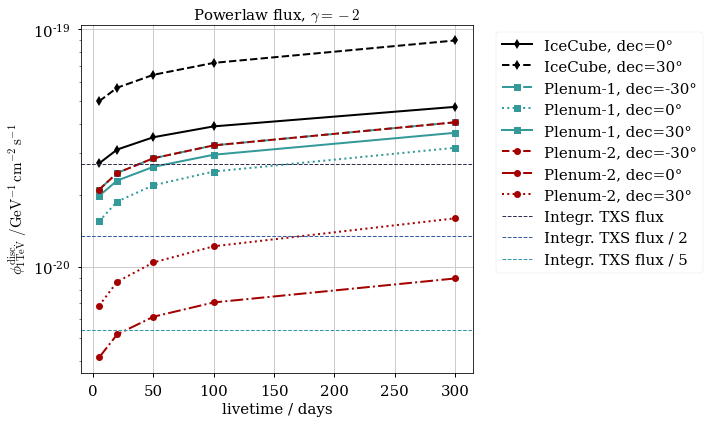

In [66]:
f, ax = plt.subplots(figsize=(10,6))
for i, ((ident, dec), series) in enumerate(flux.groupby(["ident", "dec"])):
    plt.plot(
        series.livetime,
        series.disc5,
        label=f"{ident}, dec={np.rad2deg(dec):1.0f}°",
        ls=linestyles[i%4],
        **{k: poles[ident][k] for k in ["marker", "color"]}
    )
ax.set_yscale("log")
ax.axhline(PHI_TXS, ls="--", lw=1, color=colorlist[0], label="Integr. TXS flux")
ax.axhline(PHI_TXS / 2, ls="--", lw=1, color=colorlist[1], label="Integr. TXS flux / 2")
ax.axhline(PHI_TXS / 5, ls="--", lw=1, color=colorlist[2], label="Integr. TXS flux / 5")

ax.set_xlabel(r"livetime / days")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
ax.legend(loc="upper left", bbox_to_anchor=(1.04,1)) #, fontsize="medium")
ax.set_title(r"Powerlaw flux, $\gamma=-2$")
#ax.set_xlim(0, 110)
f.tight_layout()
#ax.set_ylim(0.5e-14, 1e-13)
#f.savefig("../plots/txs_disc_pot.pdf", bbox_inches="tight")


# cutoff - 2D scan

In [33]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1, 4, num=num + 1)
cut_scaling = np.linspace(3.0, 5.0, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cut": {}}
local_SPL = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident])
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"])
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        array_source_interp(txs0506.dec.rad, aeff_2d[ident]) * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            array_source_interp(txs0506.dec.rad, aeff_2d["IceCube"]) * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids))
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    comp = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i, e_0=E0_NGC, shape="powerlaw with cutoff"
    )
    out = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 0.5, 4.1),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    bf_SPL["cut"][ident] = out[0][3]

    local_SPL["ts"][ident] = np.zeros((num + 1, num))
    local_SPL["conv"][ident] = np.zeros((num + 1, num))
    local_SPL["phi_astro"][ident] = np.zeros((num + 1, num))
    print("starting local fits...")
    for j, csc in enumerate(cut_scaling):
        for i, gsc in enumerate(gamma_astro_scaling):
            func = lambda x: ps_llh_2d_composite(
                (x[0], gsc, x[1], csc),
                mu_b_base,
                mu_s_base,
                k_i,
                e_0=E0_NGC,
                shape="powerlaw with cutoff",
            )
            local_out = fmin_l_bfgs_b(
                func,
                x0=(1.2, 0.5),
                bounds=[(0.1, 3), (0.01, 6)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL["conv"][ident][i][j] = local_out[0][0]
            local_SPL["phi_astro"][ident][i][j] = local_out[0][1]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 99.91740863596021
bf param: [0.9977295  2.38312148 1.27185662 3.72811385]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 387.8047784109814
bf param: [0.99746179 2.38675817 1.25296515 3.73978997]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797712
Signal: 1034.94424590785
bf param: [0.99998976 2.00205148 1.4322355  3.50094301]
starting local fits...
done


IceCube
Plenum-1
Plenum-2


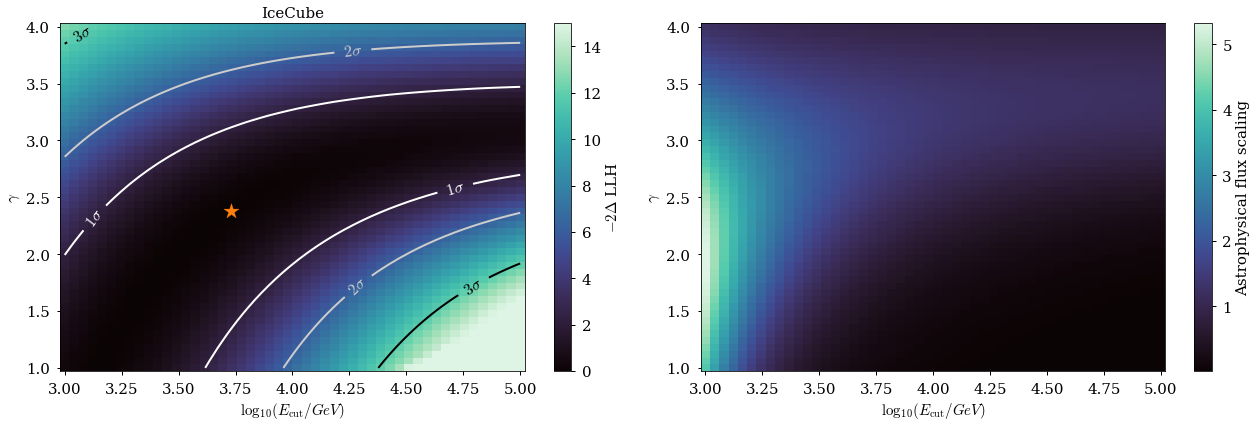

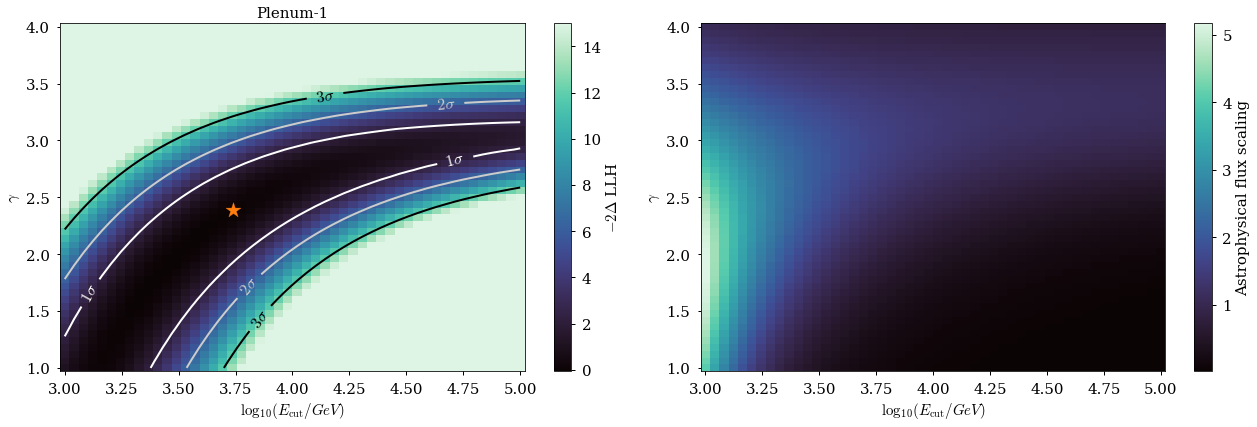

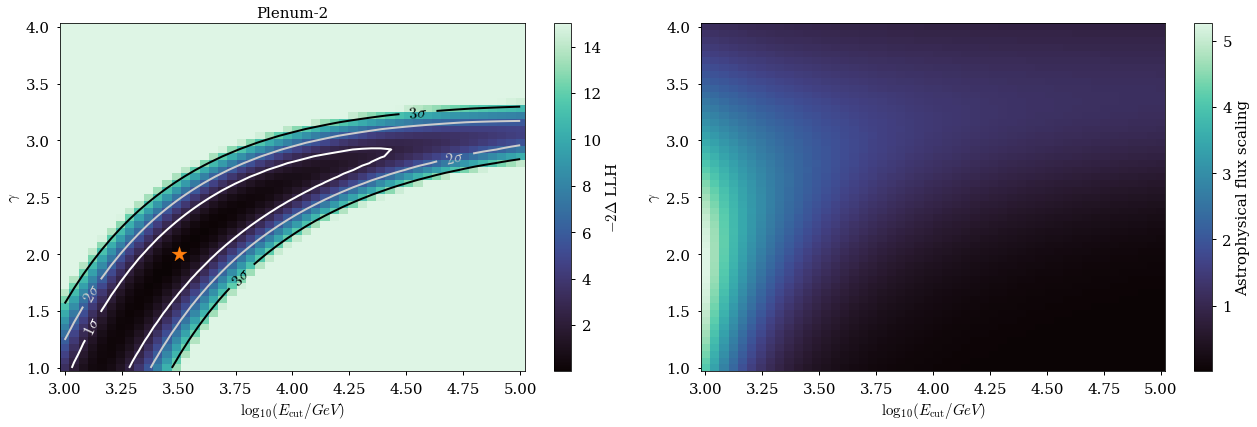

In [34]:
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["cut"][ident],
        bf_SPL["gamma"][ident],
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    # in addition, check the "nuisance" parameter of astro flux normalization
    ax = axes[1]
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["phi_astro"][ident],
    )
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")
